In [2]:
import ipywidgets as widgets
import numpy as np
import soundfile as sf
from IPython.display import display
from ipywidgets import interactive
from matplotlib import pyplot as plt
from scipy import signal
import torchaudio
import torch

from utils import rfft_plot, tf_plot
import feature_modules

In [22]:
fs = int(8 * 42.5e3)

## 音频预处理

拆分为每个一分钟的npy文件

In [20]:
x, fs_high = sf.read('audio/500m/9043_240523134537_512000_0_000000_F4.flac')
x = x.T[:-1, :]
resampler = torchaudio.transforms.Resample(fs_high, fs)
x_ds = resampler(torch.tensor(x).float()).numpy()
for i in range(60):
    np.save(f'audio/500m/{i+1}.npy', x_ds[:, i * fs: (i + 1) * fs])

## 音频分析

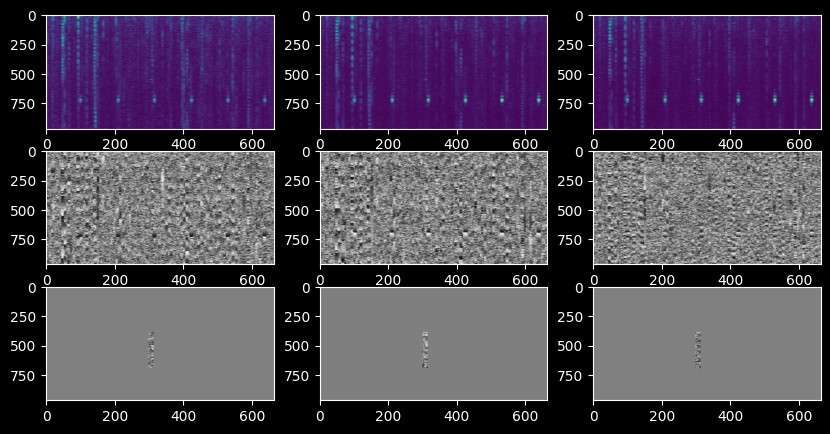

In [31]:
x = np.load('audio/500m/7.npy')
spectrogram_layer = feature_modules.Spectrogram(fs, 8192, 16).to('cuda')
filter_layer = feature_modules.Filter(fs, 8192, 42.5e3).to('cuda')
cpsd_phase_layer = feature_modules.CPSD_Phase_Spectrogram().to('cuda')
spectrogram = spectrogram_layer(torch.tensor(x).unsqueeze(0).unsqueeze(0).to('cuda'))
magnitude = torch.log1p(torch.abs(spectrogram)).squeeze().cpu().detach().numpy()
phase = cpsd_phase_layer(spectrogram).squeeze().cpu().detach().numpy()
filtered_phase = cpsd_phase_layer(filter_layer(spectrogram)).squeeze().cpu().detach().numpy()
from matplotlib.colors import Normalize
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(magnitude[i], aspect='auto')
    plt.subplot(3, 3, i+4)
    plt.imshow(phase[i], aspect='auto', cmap='gray', norm=Normalize(-np.pi, np.pi))
    plt.subplot(3, 3, i+7)
    plt.imshow(filtered_phase[i], aspect='auto', cmap='gray', norm=Normalize(-np.pi, np.pi))

## 逐帧分析

In [32]:
# f_low, f_high = 40000, 44000
f_low = 20000
f_high = 80000
fig1, ax = plt.subplots(3, 1, figsize=(15, 10))
t = np.arange(0, x.shape[1]) / fs
ax[0].plot(t, x[0])
ax[0].set_xlim(t[0], t[-1])
f, t_seg, Zxx = signal.stft(x, fs, nperseg=8192, noverlap=int(8192/4*3))
freq_low, freq_high = 10000, 50000
ax[1].pcolormesh(t_seg, f[(freq_low<f)&(f<freq_high)], np.log10(np.abs(Zxx[0, (freq_low<f)&(f<freq_high)])), cmap='gnuplot')
line1, = ax[1].plot([0] * 2, [0] * 2, 'r')
# line2, = ax[2].plot([], [], 'yo')
# line3, = ax[2].plot([], [], 'go')
line2, = ax[2].plot([], [], 'y')
line3, = ax[2].plot([], [], 'g')
ax[2].set_xlim(f_low, f_high)
ax[2].set_ylim(-np.pi, np.pi)
plt.close()  # 关闭原生显示

def plot_phi(index):
    line1.set_data(np.array([t_seg[index]] * 2), np.array([f[0], f[-1]]))
    X = Zxx[:, :, index]
    # R12_23 = np.vstack((X[0], X[1]))
    R12_23 = np.vstack((X[0] * np.conj(X[1]), X[1] * np.conj(X[2])))
    phi = - np.angle(R12_23)
    line2.set_data(f[(f_low<f)&(f<f_high)], phi[0, (f_low<f)&(f<f_high)])
    line3.set_data(f[(f_low<f)&(f<f_high)], phi[1, (f_low<f)&(f<f_high)])
    display(fig1)

slider = widgets.IntSlider(min=0, max=Zxx.shape[2]-1, step=1, value=0, continuous_update=False, readout=False, layout=widgets.Layout(width='100%'))
interactive(plot_phi, index=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', layout=Layout(width='10…

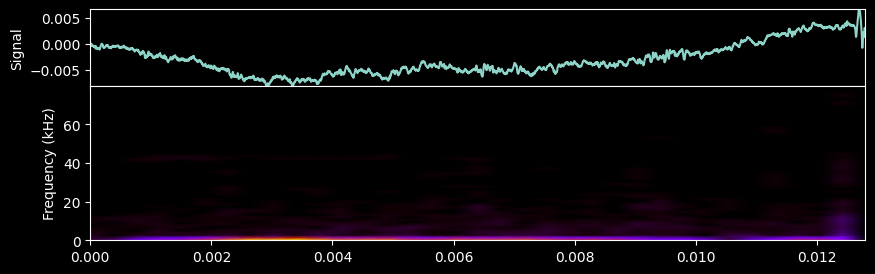

In [27]:
x0 = x[0, int(0.0075*fs):int(0.02*fs)]
# x0 = x[0, int(1.279*fs):int(1.280*fs)]
# x0 = x[0, int(2.305*fs):int(2.308*fs)]
tf_plot(x0, fs)

单独分析脉冲内相位特征

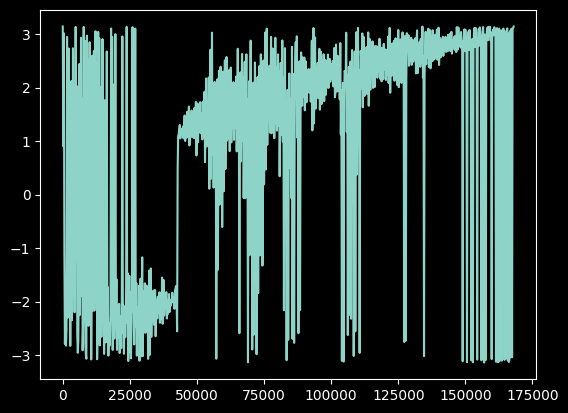

In [8]:
X0 = np.fft.rfft(x0)
f0 = np.fft.rfftfreq(x0.shape[-1], 1/fs)
plt.close()
plt.figure()
plt.plot(f0, np.angle(X0))
plt.show()